In [2]:
import pandas as pd
import matplotlib.pyplot as plt

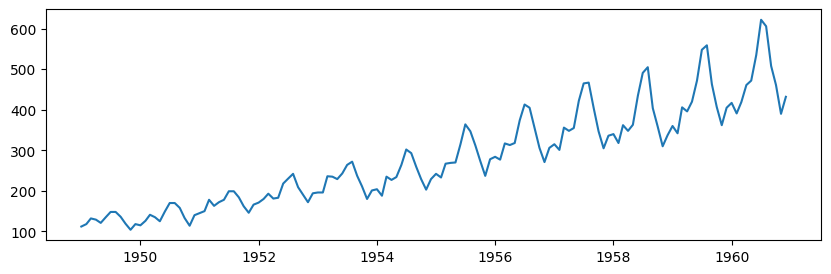

In [3]:
df = pd.read_csv("https://raw.githubusercontent.com/jbrownlee/Datasets/master/airline-passengers.csv", index_col='Month', parse_dates=True)
plt.figure(figsize=(10, 3), dpi=100)
plt.plot(df)

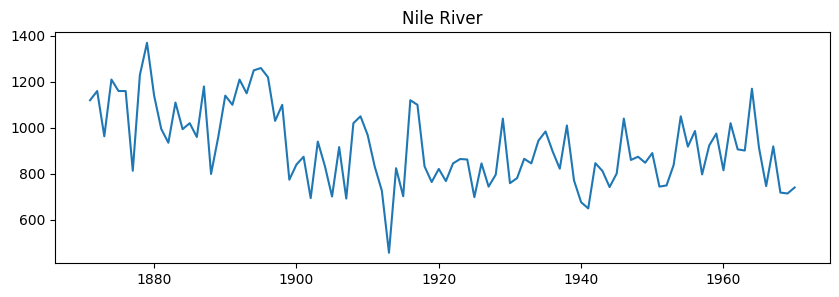

In [4]:
df = pd.read_csv("https://raw.githubusercontent.com/statsmodels/statsmodels/main/statsmodels/datasets/nile/nile.csv", index_col="year")
plt.figure(figsize=(10, 3), dpi=100)
plt.title("Nile River")
plt.plot(df)